# Assignment 1

## Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialdata2022/wiki/Assignment-1-and-2) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Monday February 28th, 2022 at 23:59. Hand in your files via [http://peergrade.io](http://peergrade.io/).

**Peergrading date and time**: _Remember that after handing in you have 1 week to evaluate a few assignments written by other members of the class_. Thus, the peer evaluations are due on Monday March 7th, 2022 at 23:59.

## Part 1: Visualizing patterns in the data

In this exercise, please generate the visualizations described below. Use the same date-ranges as in Week 2. For each set of plots, describe the plots (as you would in the figure text in a report or paper), and pick a few aspects that stand out to you and comment on those (we provided a couple of ideas during class but it's OK to add more).

We look only at the focus-crimes in the exercise below.

> *Exercise*: 
>
> * *Weekly patterns*. Basically, we'll forget about the yearly variation and just count up what happens during each weekday. [Here's what my version looks like](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/weekdays.png). Make your own version of the plot and comment your results.
> * *Hours of the week*. But by looking at just 24 hours, we may be missing some important trends that can be modulated by week-day, so let's also check out the 168 hours of the week. So let's see the number of each crime-type Monday night from midninght to 1am, Monday night from 1am-2am - all the way to Sunday night from 11pm to midnight. Visualize and comment your results.
> * *Spatial patterns*. Next, we want to generate a slightly more complicated graphic. I'm interested to know if there are certain crimes that happen much more in certain neighborhoods than what's typical:
>    - For each district plot the ratio `P(crime|district)/P(crime)` for the 14 focus crimes (follow and *show* the steps in Week 2 Ex. 2.2 for success).
>    - Comment on the top crimes in _Tenderloin_, _Mission_, and _Richmond_. Does this fit with the impression you get of these neighborhoods on Wikipedia?

In [107]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import folium
from folium import plugins
from folium.plugins import HeatMap

In [108]:
# fetching the dataset
from os import path
from urllib.request import urlopen

dataset = "Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv"
if not path.exists(dataset):
    url = "https://data.sfgov.org/api/views/tmnf-yvry/rows.csv"
    dataset = urlopen(url)
    
crime_data = pd.read_csv(dataset, parse_dates=['Date', 'Time'])

In [109]:
#helper methods, constants and settings

focuscrimes = set(['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT'])
WEEKDAY_DICT = { 'Monday': 0, 'Tuesday':1, 'Wednesday': 2, 'Thursday':3, 'Friday':4, 'Saturday': 5, 'Sunday':6 }
SIZE = 13

plt.rc('font', size=SIZE)       
plt.rc('axes', titlesize=SIZE)  
plt.rc('axes', labelsize=SIZE)  
plt.rc('xtick', labelsize=SIZE) 
plt.rc('ytick', labelsize=SIZE) 
plt.rc('legend', fontsize=SIZE) 
plt.rc('figure', titlesize=SIZE)

def sort_series_index(dict, series):
    return series.sort_index(key=lambda x : x.map(dict))

def plot_focuscrimes(data, sort_dict=None, xlabel="", ylabel="", title="", rotate_xlabel=False, ncol=2, legend_alpha=1, legend_loc=4, edges='2'):
    fig, axs = plt.subplots(len(focuscrimes) // ncol, ncol, sharex=(ncol != 1), figsize=(20, 30))

    for idx, focuscrime in enumerate(focuscrimes):
        row = idx // ncol
        col = idx % ncol

        focuscrime_data = data[focuscrime]
        if sort_dict is not None:
            focuscrime_data = sort_series_index(sort_dict, focuscrime_data)

        ax = axs[row] if ncol <= 1 else axs[row][col]

        ax.bar(focuscrime_data.index, focuscrime_data, color='thistle', edgecolor = 'black', linewidth = edges)
        ax.set_ylabel(ylabel)
        ax.legend([], title=focuscrime, frameon=1, framealpha=legend_alpha, loc=legend_loc)

        lastrow = axs[-1]
        if isinstance(lastrow, np.ndarray):
            lastrow = lastrow[col]
        lastrow.set_xlabel(xlabel)

        if(rotate_xlabel):
            for label in ax.get_xticklabels():
                label.set_rotation(45)
                label.set_ha('right')

    fig.suptitle(title, fontsize=22)
    fig.tight_layout(pad=3.0)
    plt.show()

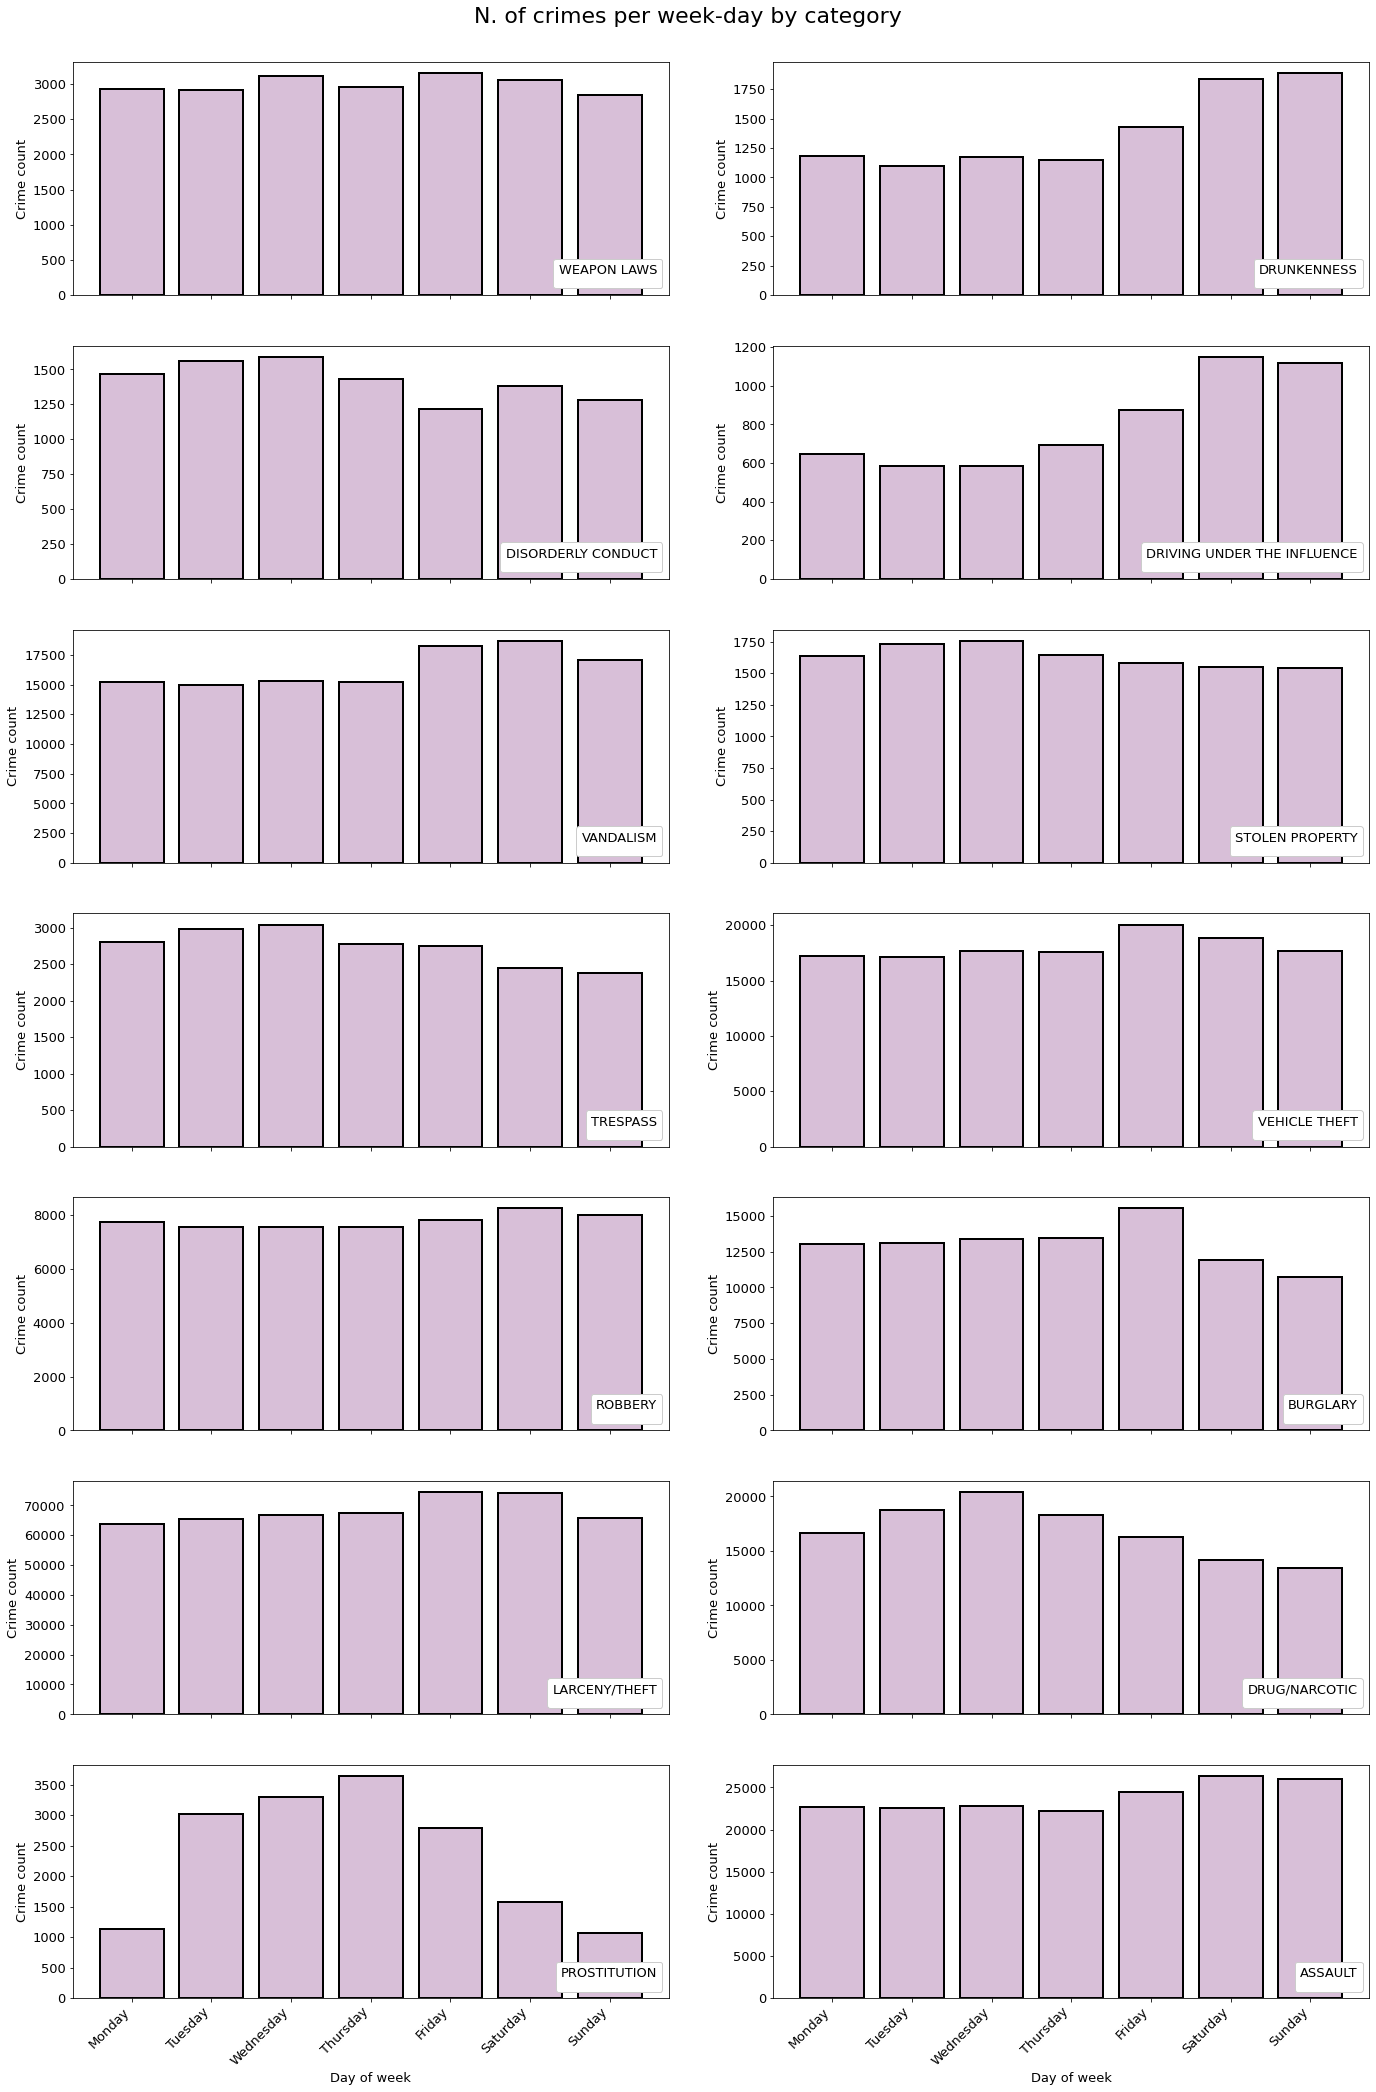

In [110]:
# Weekly patterns
crime_group = crime_data.groupby(['Category', 'DayOfWeek']).size()

plot_focuscrimes(crime_group, sort_dict=WEEKDAY_DICT, xlabel="Day of week", ylabel="Crime count", title="N. of crimes per week-day by category", rotate_xlabel=True)

> *Comments:*
> * There are some focuscrimes which are highly dependent on the weekday, for example
>   * `DRUG/NARCOTIC`, which peeks on wednesday
>   * `DRUNKENNES` and `DRIVING UNDER THE INFLUENCE`, which happen mostly during the weekend and this is really self-explanatory

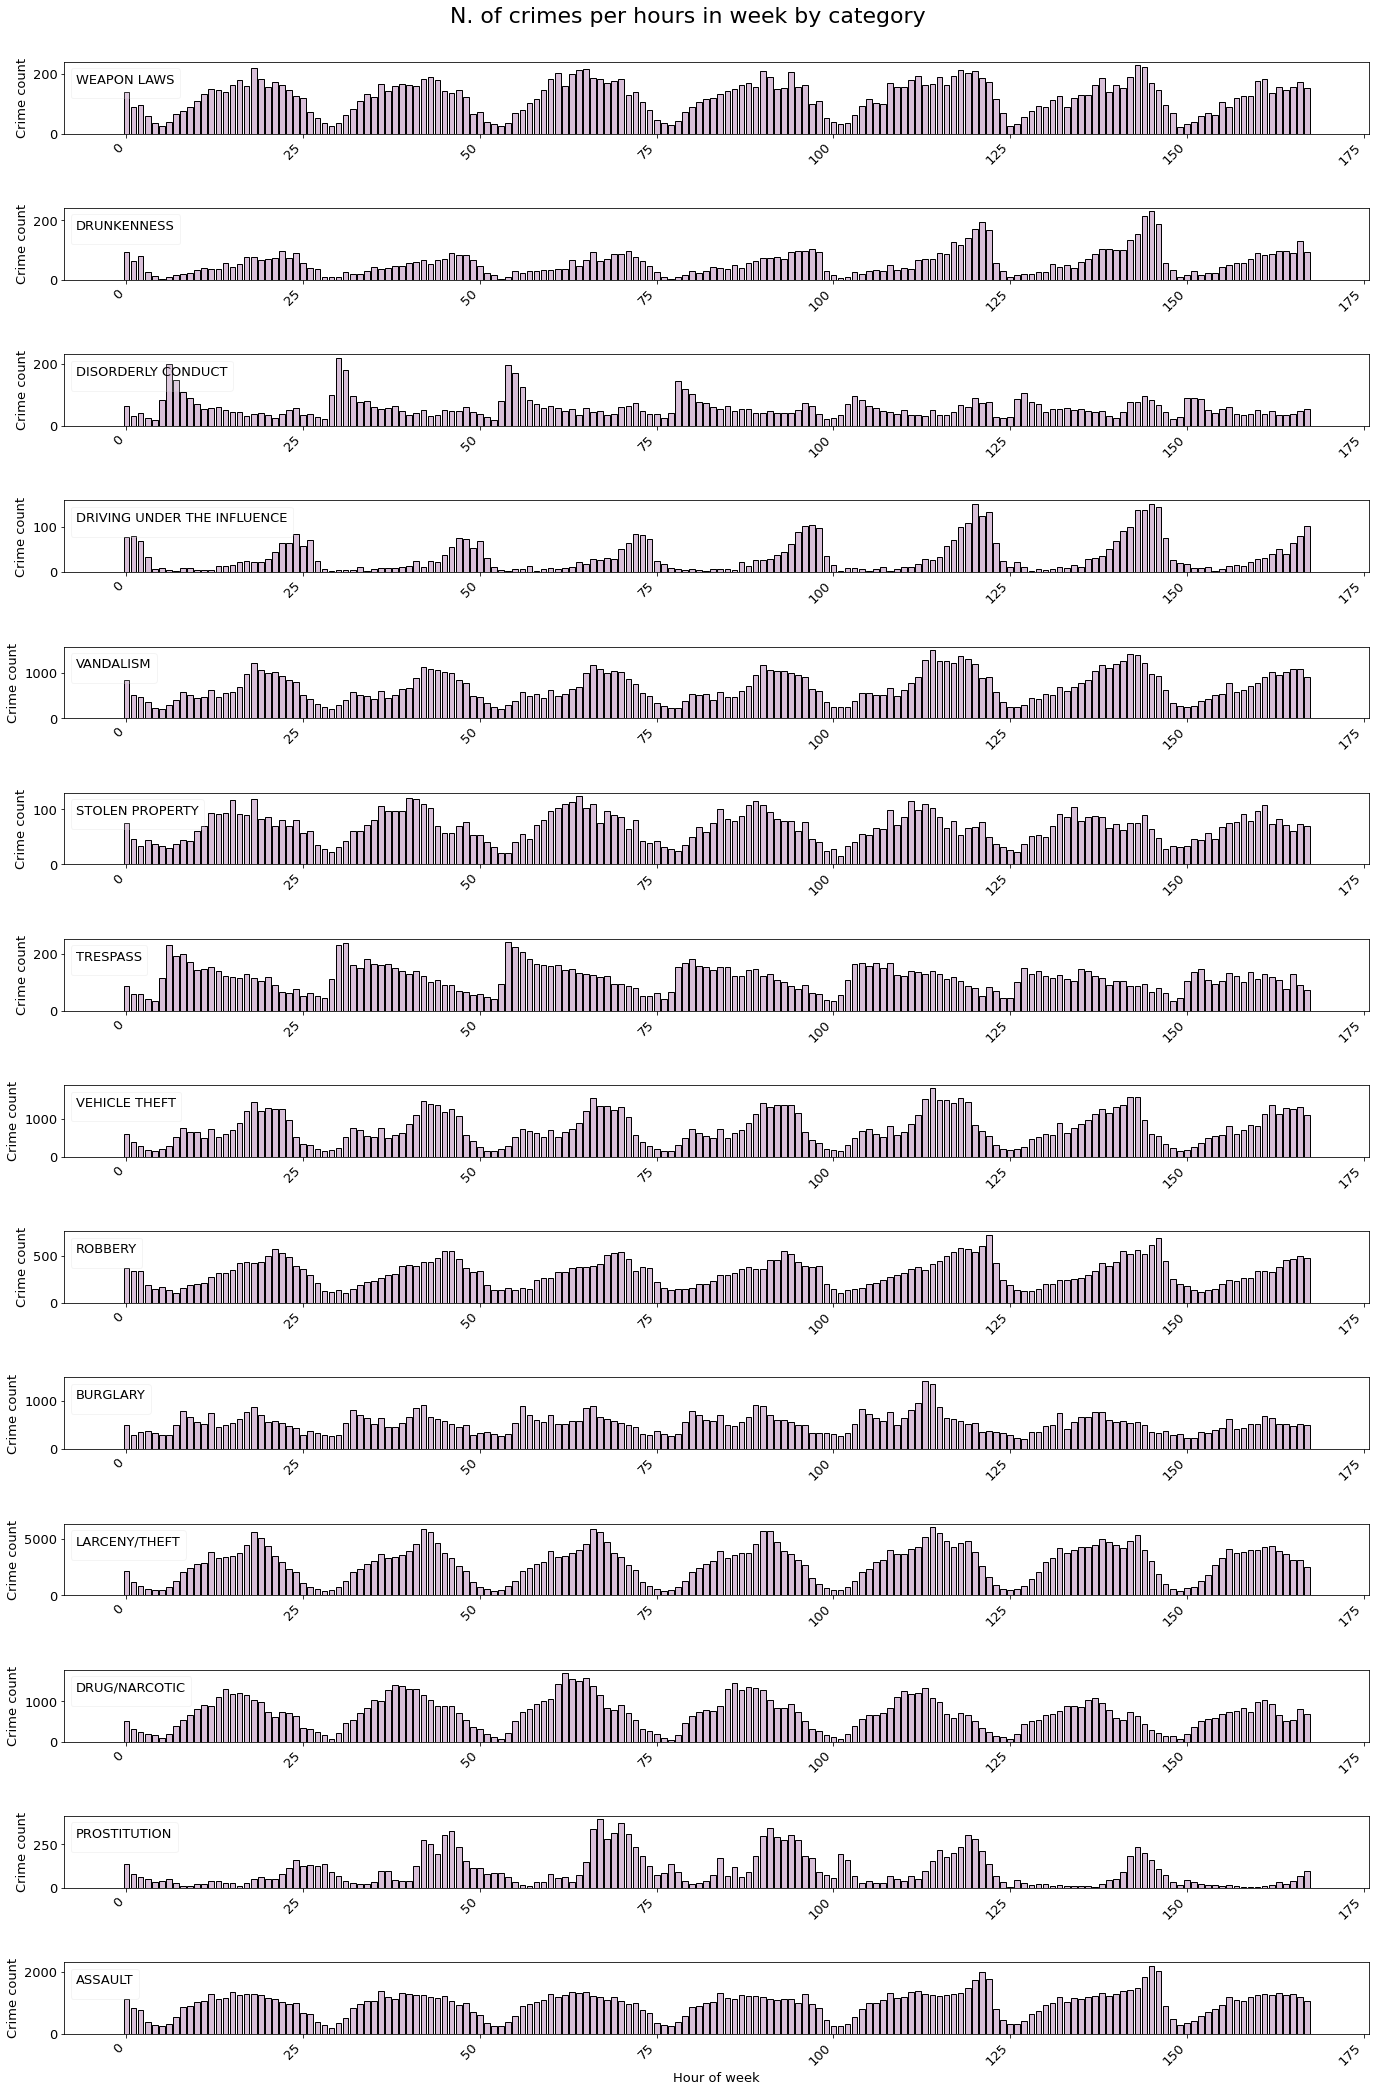

In [111]:
# Hours of the week
crime_group = crime_data.groupby(['Category' ,crime_data.Time.dt.hour + (24 * crime_data.Date.dt.dayofweek)]).size()

plot_focuscrimes(crime_group, xlabel="Hour of week", ylabel="Crime count", title="N. of crimes per hours in week by category", rotate_xlabel=True, ncol=1, legend_alpha=0.2, legend_loc=2, edges='1')

> *Comments:*
> * We looked at how `DRUNKENNESS` and `DRIVING UNDER THE INFLUENCE` relates to weekdays, but here there is an interesting observation we can make: the cases peek around midnight each day
> * Contrary to the previous example, `TRESPASS` peeks at 6am each day

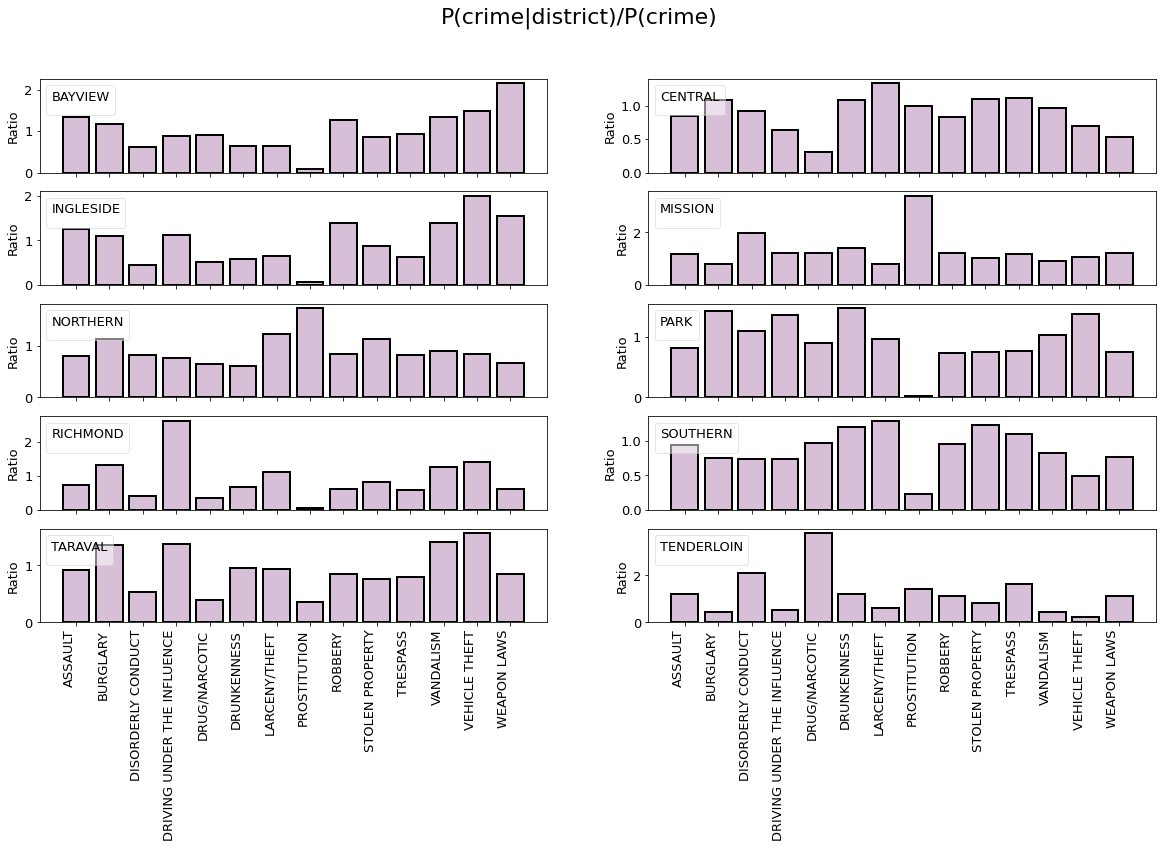

In [112]:
# Spatial Patterns
districts = sorted([district for district in set(crime_data['PdDistrict']) if pd.notnull(district)])

focuscrime_data = crime_data[crime_data.Category.isin(focuscrimes)]
by_category = focuscrime_data.groupby('Category').size().sort_values(ascending=False)
P_crime = by_category / by_category.sum()

fig, axs = plt.subplots(5,2, sharex=True, figsize=(20, 10))
for idx, district in enumerate(districts):
    by_district = focuscrime_data.query('PdDistrict == @district').groupby('Category').size().sort_values(ascending=False)
    P_crime_by_district = by_district / by_district.sum()
    data = P_crime_by_district/P_crime

    row = idx // 2
    col = idx % 2
    ax = axs[row][col]

    ax.bar(data.index, data, color='thistle', edgecolor = 'black', linewidth = '2')

    ax.set_ylabel('Ratio')
    ax.legend([], title=district, frameon=1, framealpha=0.5, loc=2)
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        label.set_ha('right')

fig.suptitle('P(crime|district)/P(crime)', fontsize=22)
plt.show()

> *Comments:*
> * Wikipedia tells us that Tenderloin has a reputation for crime, namely illegal drug trade, prostituion and strip clubs, which almost perfectly aligns with what we see on this graph
> * Mission, on the other hand, is supposed to be a neighbourhood of prostitution, but it is very hard to find anything relating to this on the wikipedia page
> * Also Richmond district (along with Sunset) is known as "The Avenues", but has little to no mention on the fact that a lot of driving under the influence would be taking place on said avenues. (in part 4 of the assignment we look at the heatmap in relation to driving under the influence)


## Part 2: Fundamentals of data visualization

In the exercise below, there is a selection of questions from Week 3, Part 1. Please, check it out if you have any doubt on how to solve the exercise.

> *Exercise:* 
>
> * *Questions from the [lecture](https://www.youtube.com/watch?v=yiU56codNlI)*. Sune mentions in the video that it's important to choose the right bin-size in histograms. But how do you do that? Do a Google search to find a criterion you like and explain it. 
> * *Hypothesis testing*. Use [data 1](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/data9b_f.csv) and [data 2](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/data9b_m.csv) to verify whether there is a statistically significant difference in the average number of steps taken by men and women. 
>     * Is there a statistically significant difference between the two groups? What is the difference between their mean number of steps? Plot two histograms to visualize the step-count distributions, and use the criterion you chose in the previous step to define the right bin-size and comment on your choice.
>     * **Pretend you did not visualize the data yet.** What was the explanation you found for what you observed? Explain the theory, news, papers, further analysis etc. you used to support your conclusions and write down a couple of sentences. Now, think of the actual shape of the data: what do you think the point of this exercise was? 
> * *Scatter plots.* Create a scatter plot with both data samples by using **your own alternative** to `color='#f6756d'` and `color='#10bdc3'`. Explain why you chose this visualization, its pros, and cons.

> *[Finding the right bin size](https://www.statisticshowto.com/choose-bin-sizes-statistics/):*
> * We like to use Sturge's rule for choosing the correct bin size: 
>   * K = 1 + 3.322log<sub>N</sub>
>   * where K is the number of bins and N is the number of observations in the set
> * This is a rough estimation of the necessary amount of bins

In [113]:
data = []
for g in ['f', 'm']:
    url = f"https://raw.githubusercontent.com/suneman/socialdata2022/main/files/data9b_{g}.csv"
    data.append(pd.read_csv(urlopen(url), sep=','))

females = data[0]
males = data[1]

def sturge_rule(N):
    return math.ceil(1 + 3.322 * math.log(N, 10))

Difference between average number of steps
Female mean: 6857.763157894737
Male mean: 7792.545232273838
Difference: 934.7820743791017


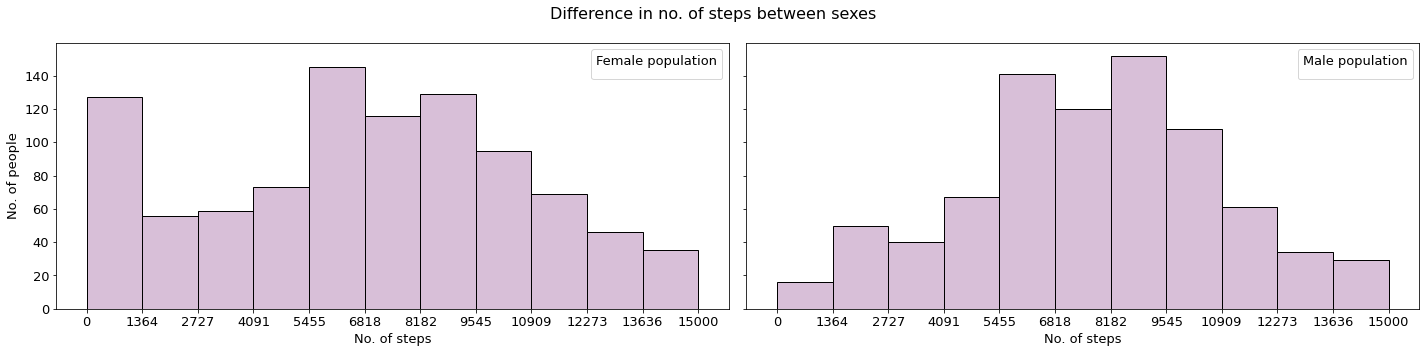

H_a: there is a sign. diff. in steps taken between males and females
H_a accepted


In [114]:
# Hypothesis testing

f_steps = females['steps']
m_steps = males['steps']

f_step_mean = f_steps.mean()
m_step_mean = m_steps.mean()
print("Difference between average number of steps")
print(f"Female mean: {f_step_mean}")
print(f"Male mean: {m_step_mean}")
print(f"Difference: {abs(m_step_mean - f_step_mean)}")

n_bins = math.ceil(np.mean([sturge_rule(len(females.index)), sturge_rule(len(males.index))]))

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(20, 5))

_, bins, _ = axs[0].hist(f_steps, bins=n_bins, range=(0, 15000), color="thistle", linewidth=1, edgecolor='black')
axs[1].hist(m_steps, bins=n_bins, range=(0, 15000), color="thistle", linewidth=1, edgecolor='black')
axs[0].set_xticks(bins)
axs[1].set_xticks(bins)
axs[0].set_ylabel("No. of people")
axs[0].set_xlabel("No. of steps")
axs[1].set_xlabel("No. of steps")
axs[0].legend([], title="Female population", frameon=1, loc=0)
axs[1].legend([], title="Male population", frameon=1, loc=0)

fig.suptitle('Difference in no. of steps between sexes', fontsize=16)
plt.show()

# H_a: there is a sign. diff. in steps taken between males and females
los = 0.05
stats_result = stats.ttest_ind(m_steps, f_steps, equal_var=True)
print('H_a: there is a sign. diff. in steps taken between males and females')
print('H_a rejected' if stats_result.pvalue > los else 'H_a accepted')

### Comments on choosing my bin size: 
> We take the average of the bin size returned by sturge's rule for both dataset
> and take their average, because for comparison we want to have the same bin size for both histograms

### Explanation for observation: 
> * [Men on average take more steps than women, they are more active](https://www.verywellfit.com/whats-typical-for-average-daily-steps-3435736),
we can also see that when looking at the huge number of women who take less then 5000 steps
> * However the distribution of steps are kind of the same between the sexes

### Point of the exercise:
> We might observe misleading information when we don't explore the dataset thoroughly enough. Analysis of the data from different perspectives might be advantageous, because we might discover something that was hidden from us in other forms of analysis. [Having a hypothesis can lead to failure of noticing important information in the dataset](https://genomebiology.biomedcentral.com/track/pdf/10.1186/s13059-020-02133-w.pdf), because we are focused on the results of the tests of our hypothesis.

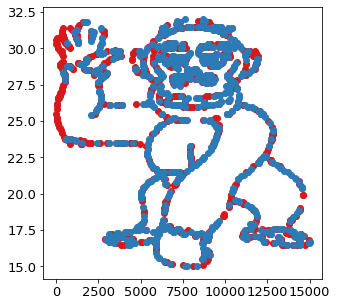

In [115]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(females['steps'], females['bmi'], color='#d7191c')
ax.scatter(males['steps'], males['bmi'], color='#2c7bb6')

plt.show()

### Explanation for color selection:
> * [We wanted to choose colors that are easily distinguishable](https://towardsdatascience.com/two-simple-steps-to-create-colorblind-friendly-data-visualizations-2ed781a167ec) by anyone regardless of color blindness. We've used a [tool](https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3) to generate colorblind-friendly color schemes, and picked two colors from the two ends of the spectrum of one scheme.
> * This choice of colors results in a plot which stands its grounds in almost every scenario of colorblindness.

## Part 3: Different types of visualization from DAOST

The exercise below, is a selection of questions from Week 3, Part 2 and 3.

> *Exercise:*
>
> * *Questions from DAOST*
>     * Janert, the author of DAOST, is so suspicious of mean, median, and related summary statistics. Explain why one has to be careful when using those - and why visualization of the full data is always better. 
>     * Explain what is a box plot. When are box plots most useful? Are violin plots better or worse than box plots? Why?
> * *Recreating plots from DAOST*. We need some box plots. Here, I'd like you to use the box plots to visualize fluctuations of how many crimes happen per day. We'll use data from the 15 focus crimes defined in Part 1.
>     * For the full time-span of the data, calulate the **number of crimes per day** within each category for the entire duration of the data.
>     * Create a box and whiskers plot showing the mean, median, quantiles, etc. for all 15 crime-types side-by-side. What does this plot reveal that you can't see in the plots from previous weeks?
>     * Now, let's calculate another average for each focus-crime, namely what time of day the crime happens. So this time, the distribution we want to plot is the average time-of-day that a crime takes place. There are many ways to do this, but let me describe one way to do it: 
>        * For datapoint, the only thing you care about is the time-of-day, so discard everything else.
>        * You also have to deal with the fact that time is annoyingly not divided into nice units that go to 100 like many other numbers. (Refer to Week 3 exercise 3.2 for hints.)      
>        * Now, you can create box-plots to create an overview of *when various crimes occur*. Note that these plot have quite a different interpretation than ones we created in the previous exercise. Comment your results. 

> *mean, median, etc:*

> *box plot:*

## PART 4: Visualizing geo-data

Let's now use the cool Folium functionalites `HeatMap` and `HeatMapWithTime` to create a visualization of the patterns of your favorite crime-type and how they change over time. 

**Note** The exercise below is a mix of exercise 1.2 (**but with the data you choose**) and 1.3 from Week 4.

> *Exercise*: Heatmaps and heatmap movies. you get to make all the choices, but remember to **explain and motivate them**.
> * Start by choosing a crimetype with spatial patterns that change over time. Use your data-exploration from the previous lectures to choose a good one.
> * Create a heatmap by grabbing your crimetype data across all times. Play with parameters to get plots you like and explain why you chose them and what the effect of these parameters are.
> * Now, choose a time-resolution. You could plot daily, weekly, monthly datasets to plot in your movie. Again the goal is to find interesting temporal patterns to display. We want at least 20 frames though. Create the movie using `HeatMapWithTime`.
> * Comment on your results: 
>   - What patterns does your movie reveal?
>   - Motivate/explain the reasoning behind your choice of crimetype and time-resolution (you can also refer to exercises/visualizations that we have done in class to motivate your choice). 

In [116]:
# Choosing a crime type
crimetype = 'DRIVING UNDER THE INFLUENCE'

In [117]:
# Creating a heatmap
drunk_driving = crime_data[crime_data.Category == crimetype]
drunk_driving_map = folium.Map(location=[37.76, -122.446747], zoom_start=13, tiles="Stamen Toner")
drunk_driving_data = [[row['Y'], row['X']] for _, row in drunk_driving.iterrows()]
HeatMap(drunk_driving_data, min_opacity=0.1, radius=30).add_to(drunk_driving_map)

drunk_driving_map

In [118]:
# Time resolution
# We analyzed driving under the influence over a 24 hour period
drunk_driving_map = folium.Map(location=[37.76, -122.446747], zoom_start=13, tiles="Stamen Toner")
drunk_driving_data = [[[row['Y'], row['X']] for _, row in drunk_driving[drunk_driving.Time.dt.hour == hour].iterrows()] for hour in range(0,24)]
favorite_crime_heatmap = plugins.HeatMapWithTime(drunk_driving_data, auto_play=True)
favorite_crime_heatmap.add_to(drunk_driving_map)

drunk_driving_map

### Comment on patterns
> Driving under the influence over a 24 hour period:
> * during the day (6am to 4pm) there are way less cases than in the afternoon/night
> * number of cases peak during the night and are most prelevant in Tenderloin, the streets of Mission and the Geary Boulevard
> * from 4pm there are an increasing amount of cases around the pubs in Tenderloin, up until 5am
> * from 23pm to 6am there are an increasing amount of cases on the Geary Boulevard, which leads to Richmond district, where people live.

### Reasoning behind our choice of crimetype and time-resolution
> We had a hypothesis that during the day there are way less people driving under the influence than in the afternoon/night.
> This was also confirmed by the exercise on temporal patterns in week 2, where we saw a clear and significant difference in number of cases over this period. 

![temporal_patterns](https://raw.githubusercontent.com/xelahalo/socialdata2022/main/driving_under_the_influence_24h.png)


> This was really easy to see on the heatmap.

## Part 5: Errors in the data. 

We started the course by plotting simple histogram and bar plots that showed a lot of cool patterns. But sometimes the binning can hide imprecision, irregularity, and simple errors in the data that could be misleading. In the work we've done so far, we've already come across at least three examples of this in the SF data. 

1. In the temporal activity for `PROSTITUTION` something surprising is going on on Thursday. Remind yourself [**here**](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/prostitution.png), where I've highlighted the phenomenon I'm talking about.
2. When we investigated the details of how the timestamps are recorded using jitter-plots, we saw that many more crimes were recorded e.g. on the hour, 15 minutes past the hour, and to a lesser in whole increments of 10 minutes. Crimes didn't appear to be recorded as frequently in between those round numbers. Remind yourself [**here**](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/jitter.png), where I've highlighted the phenomenon I'm talking about.
3. And, during Week 4 we saw that the Hall of Justice seemed to be an unlikely hotspot for sex offences. Remind yourself [**here**](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/crime_hot_spot.png).

> *Exercise*: Data errors. The data errors we discovered above become difficult to notice when we aggregate data (and when we calculate mean values, as well as statistics more generally). Thus, when we visualize, errors become difficult to notice when binning the data. We explore this process in the exercise below:
>
> * In each of the examples above, describe in your own words how the data-errors, I call attention to above, can bias the binned versions of the data. Also, briefly mention how not noticing these errors can result in misconceptions about the underlying patterns of what's going on in San Francisco (and our modeling).
> * Find your own example of human noise in the data and visualize it. Comment your results.

In [119]:
# Finding our own error

# assert pd.Series(crime_data['IncidntNum']).is_unique
incident_number_grouped = crime_data.groupby(crime_data.IncidntNum).size().sort_values()
reported_multiple_times = [i for i in incident_number_grouped.values if i > 1]
excess_incidents = np.sum(reported_multiple_times) - len(reported_multiple_times) # -> 425899
excess_incidents/len(crime_data) # -> accounts for almost 19.99% of the records

## Our newfound error
> Due to process behind recording these incidents, there is something we might have overlooked. There are multiple records with the same incident number, which could have more than one possible explanations, like police raids. This, of course, doesn't mean that those cases are invalid, for example multiple people could have been arrested who were involved in an illegal group activity and they each take a record in our dataset. However these incidents all bear the same date, hour and some of them belong to the same category, so we can falsly interpret them as unique occurrances. This can lead us astray. For example these "excess" incidents account for almost 20% of the records! If we visualize the differences something strange happens.

In [136]:
# incidents_reported_multiple_times = [idx for idx, val in enumerate(incident_number_grouped) if val > 1]
# incidents_reported_multiple_times

crime_data_without_duplicates = crime_data.drop_duplicates(subset=['IncidntNum'])
original_by_time = crime_data.groupby(crime_data.Date.dt.dayofweek).size()
duplicate_removed_by_time = crime_data_without_duplicates.groupby(crime_data.Date.dt.dayofweek).size()

crime_data.boxplot(by=crime_data.Date)
crime_data_without_duplicates.boxplot(by=crime_data_without_duplicates.Date)

# fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(20, 5))

# axs[0].box)
# axs[1].boxplot(duplicate_removed_by_time.index, duplicate_removed_by_time)
# axs[0].set_ylabel("No. of incidents")
# axs[0].set_xlabel("Day of the year")
# axs[1].set_xlabel("Day of the year")
# axs[0].legend([], title="Before", frameon=1, loc=0)
# axs[1].legend([], title="After", frameon=1, loc=0)


TypeError: unhashable type: 'Series'